# $\ell 1$ Wavelet Regularized Reconstruction

This notebook reproduce experiments with $\ell 1$ wavelet regularized reconstruction described in [Accelerating Non-Cartesian MRI Reconstruction Convergence using k-space Preconditioning](https://arxiv.org/abs/1902.09657).

In [1]:
%matplotlib notebook

import sigpy as sp
import sigpy.mri as mr
import sigpy.plot as pl
import matplotlib.pyplot as plt
import numpy as np

## Set parameters and load dataset

In [2]:
max_iter = 1000
lamda = 0.001
ksp_file = 'data/spiral/ksp.npy'
coord_file = 'data/spiral/coord.npy'

# Choose computing device.
# Device(-1) specifies CPU, while others specify GPUs.
# GPU requires installing cupy.
device = sp.Device(-1)
xp = device.xp
device.use()

# Load datasets.
ksp = xp.load(ksp_file)
coord = xp.load(coord_file)

## Estimate sensitivity maps using JSENSE

Here we use [JSENSE](https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.21245) to estimate sensitivity maps.

In [3]:
mps = mr.app.JsenseRecon(ksp, coord=coord, device=device).run()

## Conjugate Gradient reconstruction

<IPython.core.display.Javascript object>


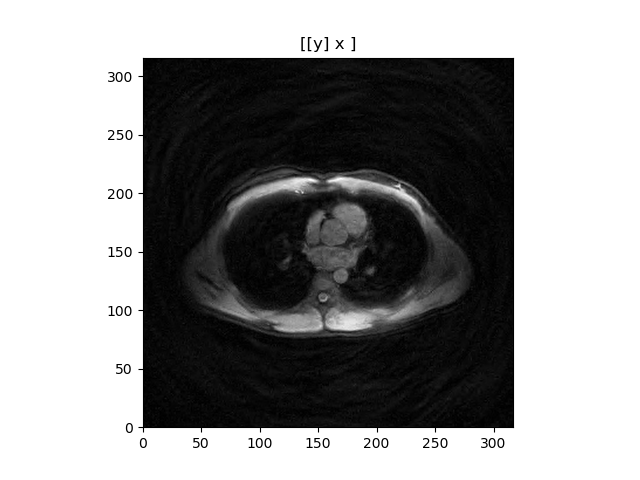

In [4]:
fista_app = mr.app.L1WaveletRecon(
        ksp, mps, lamda=lamda, coord=coord, device=device,
        max_iter=max_iter, save_objective_values=True)

fista_img = fista_app.run()

pl.ImagePlot(fista_img)

## Primal dual hybrid gradient reconstruction

<IPython.core.display.Javascript object>


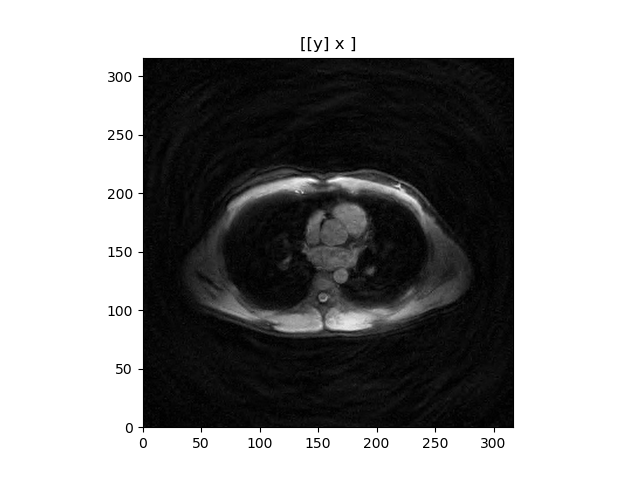

In [5]:
pdhg_app = mr.app.L1WaveletRecon(
        ksp, mps, lamda=lamda, coord=coord, max_iter=max_iter,
        alg_name='PrimalDualHybridGradient', device=device, save_objective_values=True)
pdhg_img = pdhg_app.run()

pl.ImagePlot(pdhg_img)

## Proposed reconstruction

<IPython.core.display.Javascript object>


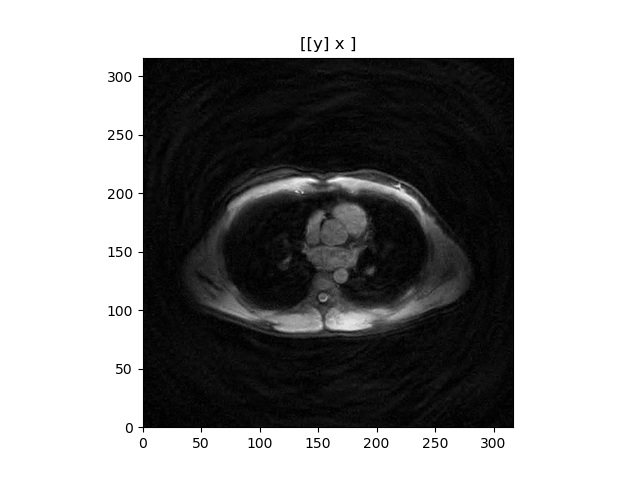

In [6]:
# Compute preconditioner
precond = mr.kspace_precond(mps, coord=coord, device=device)

precond_app = mr.app.L1WaveletRecon(
        ksp, mps, lamda=lamda, coord=coord, sigma=precond, max_iter=max_iter,
        alg_name='PrimalDualHybridGradient', device=device, save_objective_values=True)
precond_img = precond_app.run()

pl.ImagePlot(precond_img)

## Convergence curves

<IPython.core.display.Javascript object>


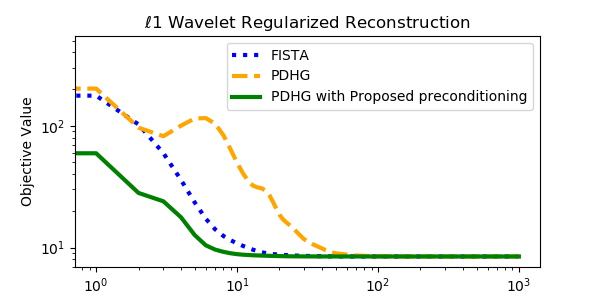

In [7]:
plt.figure(figsize=(6, 3))
plt.loglog(fista_app.objective_values,
            linestyle=':', linewidth=3, color='blue')
plt.loglog(pdhg_app.objective_values,
               linestyle='--', linewidth=3, color='orange')
plt.loglog(precond_app.objective_values,
               linestyle='-', linewidth=3, color='green')
plt.legend(['FISTA',
            'PDHG',
            'PDHG with Proposed preconditioning'])
plt.ylabel('Objective Value')
plt.xlabel('Iteration')
plt.title(r"$\ell 1$ Wavelet Regularized Reconstruction")
plt.show()